##Loading Files from drive
The command below is to load files from drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Libraries
Numpy, Pandas, Torch, PIL, Torchvision, matplotlib and os libraries are imported

In [0]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms

##Dataset loading
The dataset class is inherited and customized as per the dataset given. RandomResizedCrop, RandomHorizontalFlip are used as data augmentation techniques. The dataset is also normalized to obtain better results.

In [0]:
class DataSet(Dataset):
    def __init__(self, root_dir, total_no, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.total_no = total_no
        self.csv_file = np.array(pd.read_csv(csv_file, header=None))[0]

    def __len__(self):
        return self.total_no

    def __getitem__(self, image_no):
        img_name = os.path.join(self.root_dir, str(image_no+1)+".jpg")
        image = Image.open(img_name)
        sample = {'image': image, 'category': self.csv_file[image_no]-1}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample
  
trainDataset = DataSet('/content/drive/My Drive/HW3_data/train/', 
                       1888,
                       '/content/drive/My Drive/HW3_data/train_labels.csv', 
                       transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
testDataset = DataSet('/content/drive/My Drive/HW3_data/test/', 
                      800, 
                      '/content/drive/My Drive/HW3_data/test_labels.csv', 
                      transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

##Dataloaders for loading the datasets defined
Train and test dataloaders are defined with batch size 4, number of workers 4 and shuffling while loading data has been enabled.

In [0]:
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=4,
                                              shuffle=True, num_workers=4)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=4,
                                             shuffle=True, num_workers=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Displaying the images
The images are displayed along with their classes after loading data

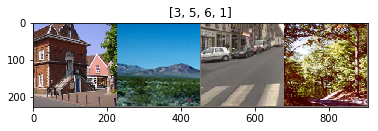

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
inputs = next(iter(trainDataloader))
out = torchvision.utils.make_grid(inputs['image'])
imshow(out, title=[int(x) for x in inputs['category']])


##Defining the ResNet18 model
The 18 layers for ResNet has been built as follows consisting of 4 blocks each consisting of 2 similar blocks each having 2 convolution layers. The input image is immediately passed into a convolution layer followed by these 4 blocks and then finally into a fully connected layer leading to 18 layers.

In [0]:
class BasicBlock(torch.nn.Module):
  def __init__(self, in_filters, out_filters, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    
    self.conv1 = torch.nn.Conv2d(in_filters, out_filters, 3, stride, 1, bias = False)
    self.bn1 = torch.nn.BatchNorm2d(out_filters)
    self.relu = torch.nn.ReLU(inplace = True)
    
    self.conv2 = torch.nn.Conv2d(out_filters, out_filters, 3, 1, 1, bias = False)
    self.bn2 = torch.nn.BatchNorm2d(out_filters)
    
    self.downsample = downsample
    self.stride = stride
  def forward(self, inp):
    previous_inp = inp
    output = self.conv1(inp)
    output = self.bn1(output)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.bn2(output)
    if(self.downsample is not None):
      previous_inp = self.downsample(inp)
    output += previous_inp
    output = self.relu(output)
    return output
    
    
class ResNet18(torch.nn.Module):
  def __init__(self, num_classes=8):
    super(ResNet18, self).__init__()
    self.inplanes = 64
    self.conv1 = torch.nn.Conv2d(3, self.inplanes, 7, 2, 3, bias = False)
    self.bn1 = torch.nn.BatchNorm2d(self.inplanes)
    self.relu = torch.nn.ReLU(inplace = True)
    self.maxpool = torch.nn.MaxPool2d(3, 2, 1)
    
    self.layer1 = self._make_layer(64, 2)
    self.layer2 = self._make_layer(128, 2, stride = 2)
    self.layer3 = self._make_layer(256, 2, stride = 2)
    self.layer4 = self._make_layer(512, 2, stride = 2)
    
    self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    self.fc = torch.nn.Linear(512, num_classes)
    
    for module in self.modules():
      if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, mode='fan_out',
                                      nonlinearity='relu')
      elif isinstance(module, torch.nn.BatchNorm2d):
        torch.nn.init.constant_(module.weight, 1)
        torch.nn.init.constant_(module.bias, 0)
    
  def _make_layer(self, out_planes, blocks, stride = 1):
    downsample = None
    if(stride != 1 or out_planes != self.inplanes):
      downsample = torch.nn.Sequential(
          torch.nn.Conv2d(self.inplanes, out_planes, kernel_size=1, 
                          stride=stride, bias = False),
          torch.nn.BatchNorm2d(out_planes)
      )
    layers = []
    layers.append(BasicBlock(self.inplanes, out_planes, stride, downsample))
    self.inplanes = out_planes
    for _ in range(1, blocks):
      layers.append(BasicBlock(self.inplanes, out_planes))
    return torch.nn.Sequential(*layers)
  
  def forward(self, inp):
    inp = self.conv1(inp)
    inp = self.bn1(inp)
    inp = self.relu(inp)
    inp = self.maxpool(inp)
    
    inp = self.layer1(inp)
    inp = self.layer2(inp)
    inp = self.layer3(inp)
    inp = self.layer4(inp)
    
    inp = self.avgpool(inp)
    inp = inp.view(inp.size(0), -1)
    inp = self.fc(inp)
    
    return inp
    

##Printing the ResNet model
The ResNet architecture is shifted to CUDA(GPU) and is printed in the following lines.

In [0]:
myResnet = ResNet18().to(device)
print(myResnet)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): 

##Defining Optimizer, Loss functions and Learning rate scheduler
The optimizer function, loss function and the learning rate scheduler are defined in the following segment of code.

In [0]:
Loss = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(myResnet.parameters(), lr=0.01)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(Optimizer, step_size=2, gamma=0.9)

##Function for running the defined model
The function is defined for loading the data for each epoch, outputing the output for the batch and performing backpropagation using the defined optimizer.

In [0]:
def run_model(model, epochs, loss, optimizer, trainDataloader, testDataloader):
  model.to(device)
  for epoch in range(epochs):
    current_loss = 0.0
    exp_lr_scheduler.step()
    for i, data in enumerate(trainDataloader, 0):
      images, labels = data['image'], data['category']
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      obtained_outputs = model(images)
      obtained_loss = loss(obtained_outputs, labels)
      obtained_loss.backward()
      optimizer.step()
      current_loss += obtained_loss.item()
      if(i%100 == 99):
        print("EPOCH:", epoch+1)
        print("BATCH:", i+1)
        print("LOSS:", current_loss/100)
        print("----------------------------")
        current_loss = 0.0
  print("Training Done!!!")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testDataloader:
      images, labels = data['image'], data['category']
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      predicted_output = torch.argmax(outputs, 1)
      correct += (predicted_output == labels).sum().item()
      total += labels.size(0)
  print("Accuracy:", correct*100/total, "%")

##Running the model
Resnet model is run for 200 epochs with the defined Cross Entropy Loss and Adam Optimizer.

In [0]:
run_model(myResnet, 200, Loss, Optimizer, trainDataloader, testDataloader)

##Training Accuracy
The trained model is run on the train dataset. Accuracy of 88.88% is obtained.

In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in trainDataloader:
    images, labels = data['image'], data['category']
    images, labels = images.to(device), labels.to(device)
    outputs = myResnet(images)
    predicted_output = torch.argmax(outputs, 1)
    correct += (predicted_output == labels).sum().item()
    total += labels.size(0)
print("Training Accuracy:", correct*100/total, "%")

Training Accuracy: 88.87711864406779 %


## Testing Accuracy
The trained model is run on the test dataset. Accuracy of 90.375% is obtained.

In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in testDataloader:
    images, labels = data['image'], data['category']
    images, labels = images.to(device), labels.to(device)
    outputs = myResnet(images)
    predicted_output = torch.argmax(outputs, 1)
    correct += (predicted_output == labels).sum().item()
    total += labels.size(0)
print("Test Accuracy:", correct*100/total, "%")

Test Accuracy: 90.375 %


##Loading the CIFAR10 dataset
The train dataset and test dataset are loaded and appropriate transformations are applied.  The dataloaders are also loaded with batch size 256 and number of workers=2

In [0]:
cifarTrainSet = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             download = True, 
                                             transform = transforms.Compose([
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5, 0.5, 0.5), 
                                                                       (0.5, 0.5, 0.5))]))
cifarTestSet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download = True,
                                           transform = transforms.Compose([
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5),
                                                                   (0.5, 0.5, 0.5))
                                           ]))
cifarTrainLoader = torch.utils.data.DataLoader(cifarTrainSet, batch_size=256,
                                              shuffle=True, num_workers=2)
cifarTestLoader = torch.utils.data.DataLoader(cifarTestSet, batch_size=256,
                                              shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


##Configuring Resnet18
The Resnet18 is configured as per CIFAR10 dataset with 10 nodes in the final layer, representing probabilities for each output.

In [0]:
cifarResnet = ResNet18(num_classes=10).to(device)
print(cifarResnet)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): 

## Loss function  and optimizer
The loss function and optimizer are defined for the new model of Resnet as follows:


In [0]:
Loss = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(cifarResnet.parameters(), lr=0.01)

##Function for running the new  model
The function is defined for loading CIFAR10 data for each epoch, outputing the output for the batch and performing backpropagation using the defined optimizer.


In [0]:
def run_model(model, epochs, loss, optimizer, trainDataloader, testDataloader):
  model.to(device)
  for epoch in range(epochs):
    current_loss = 0.0
    for i, data in enumerate(trainDataloader, 0):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      obtained_outputs = model(images)
      obtained_loss = loss(obtained_outputs, labels)
      obtained_loss.backward()
      optimizer.step()
      current_loss += obtained_loss.item()
      if(i%100 == 99):
        print("EPOCH:", epoch+1)
        print("BATCH:", i+1)
        print("LOSS:", current_loss/100)
        print("----------------------------")
        current_loss = 0.0
  print("Training Done!!!")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testDataloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      predicted_output = torch.argmax(outputs, 1)
      correct += (predicted_output == labels).sum().item()
      total += labels.size(0)
  print("Accuracy:", correct*100/total, "%")

## Running the model
Resnet model is run for 20 epochs with the defined Cross Entropy Loss and Adam Optimizer.

In [0]:
run_model(cifarResnet, 20, Loss, Optimizer, cifarTrainLoader, cifarTestLoader)

##Training Accuracy
The trained model is run on the train dataset. Accuracy of 94.736% is obtained.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in cifarTrainLoader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = cifarResnet(images)
      predicted_output = torch.argmax(outputs, 1)
      correct += (predicted_output == labels).sum().item()
      total += labels.size(0)
print("Training Accuracy:", correct*100/total, "%")

Training Accuracy: 94.736 %


##Testing Accuracy
The trained model is run on the test dataset. Accuracy of 78.51% is obtained.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in cifarTestLoader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = cifarResnet(images)
      predicted_output = torch.argmax(outputs, 1)
      correct += (predicted_output == labels).sum().item()
      total += labels.size(0)
print("Testing Accuracy:", correct*100/total, "%")

Testing Accuracy: 78.51 %


##Comparision among KNN, Alexnet, Resnet18
### KNN : 55.5% accuracy.
### Alexnet pretrained model : 93.25% accuracy
### Resnet18 : 90.375% accuracy.
